In [ ]:
pip install ftfy

     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=7dbc2f71f16f1e24bbe7fc262b9a959c8ef91b8ed84e489f853c60b4cd2d6e14
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy


In [ ]:
pip install word2vec-sisg

  Created wheel for word2vec-sisg: filename=word2vec_SISG-1.0.0-py3-none-any.whl size=4042 sha256=d62271b3252f77e6f5422de76a1ede1481ff629d1b6fe6e81d3d0f1d566155bd
  Stored in directory: /root/.cache/pip/wheels/08/0a/c9/425110646318a04ff2228dc6d5ba1d42645b96c16c576e380d
Successfully built word2vec-sisg


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from textblob import TextBlob
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")
import ftfy
#from bs4 import BeautifulSoup

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import word2vec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Reproducibility
np.random.seed(1234)

DEPRES_NROWS = 15000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 10000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.5
EPOCHS= 5

In [ ]:
DEPRESSIVE_TWEETS_CSV = 'dep.csv' 
RANDOM_TWEETS_CSV = 'sa.csv'

In [ ]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, usecols = range(0,7), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(1,4), nrows = RANDOM_NROWS)

In [ ]:
random_tweets_df.head()

,Sentiment,SentimentSource,SentimentText
0,0,Sentiment140,is so sad for my APL frie...
1,0,Sentiment140,I missed the New Moon trail...
2,1,Sentiment140,omg its already 7:30 :O
3,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [ ]:
depressive_tweets_df.head()

,id,Unnamed: 0,cashtags,hashtags,id.1,time,tweet
0,0,0.0,[],[],1.151350e+18,21:25:13,"Wow, my dad yday: “you don’t take those stupid..."
1,1,1.0,[],[],1.151350e+18,21:25:07,what part of this was really harmfult of a lot...
2,2,2.0,[],"['#depression', '#uncoveringthenewu', '#change...",1.151350e+18,21:25:06,one of the ways I got through my #depression i...
3,3,3.0,[],[],1.151350e+18,21:24:55,see i wanna do one of them but they all say th...
4,4,4.0,[],[],1.151350e+18,21:24:51,IS IT clinical depression or is it the palpabl...


### Data Cleaning

In [ ]:
#removing emojis
depressive_tweets_df=depressive_tweets_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
random_tweets_df=random_tweets_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

random_tweets_df.head(20)

,Sentiment,SentimentSource,SentimentText
0,0,Sentiment140,is so sad for my APL frie...
1,0,Sentiment140,I missed the New Moon trail...
2,1,Sentiment140,omg its already 7:30 :O
3,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,Sentiment140,i think mi bf is cheating on me!!! ...
5,0,Sentiment140,or i just worry too much?
6,1,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sentiment140,Sunny Again Work Tomorrow :-| ...
8,1,Sentiment140,handed in my uniform today . i miss you ...
9,1,Sentiment140,hmmmm.... i wonder how she my number @-)


In [ ]:
#url
df['tweet_clean'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df.sample(5)

In [ ]:
#remove duplicates
print(df.shape[0])
df.drop_duplicates(subset=['id'], inplace=True, keep='last')
print(df.shape[0])

In [ ]:
#removing punctuation
import string
string.punctuation

#punctuation marks

def remove_punct(text):
    text_nopunct = "".join([char for char in str(text) if char not in string.punctuation])
    return text_nopunct

depressive_tweets_df['tweet_clean'] = depressive_tweets_df['tweet_clean'].apply(lambda x: remove_punct(x))
random_tweets_df['tweet_clean'] = random_tweets_df['tweet_clean'].apply(lambda x: remove_punct(x))

random_tweets_df.head()

,Sentiment,SentimentSource,SentimentText,tweet_clean
0,0,Sentiment140,is so sad for my APL frie...,is so sad for my APL friend
1,0,Sentiment140,I missed the New Moon trail...,I missed the New Moon trailer
2,1,Sentiment140,omg its already 7:30 :O,omg its already 730 O
3,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,Omgaga Im sooo im gunna CRy Ive be...
4,0,Sentiment140,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me TT


In [ ]:
#turning into lowercase
depressive_tweets_df['tweet_clean'] = depressive_tweets_df['tweet_clean'].str.lower()
depressive_tweets_df.head()
random_tweets_df['tweet_clean'] = random_tweets_df['tweet_clean'].str.lower()
random_tweets_df.head()

,Sentiment,SentimentSource,SentimentText,tweet_clean
0,0,Sentiment140,is so sad for my APL frie...,is so sad for my apl friend
1,0,Sentiment140,I missed the New Moon trail...,i missed the new moon trailer
2,1,Sentiment140,omg its already 7:30 :O,omg its already 730 o
3,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im sooo im gunna cry ive be...
4,0,Sentiment140,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me tt


In [ ]:
#removing numbers
depressive_tweets_df['tweet_clean'] = depressive_tweets_df['tweet_clean'].str.replace('\d+', '')
random_tweets_df['tweet_clean'] = random_tweets_df['tweet_clean'].str.replace('\d+', '')

In [ ]:
#removing stop words
def remove_stopwords(txt):
            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(txt) 
            filtered_sentence = ' '.join([w for w in word_tokens if not w in stop_words])
            return filtered_sentence
depressive_tweets_df['tweet_clean'] = depressive_tweets_df['tweet_clean'].apply(lambda x: remove_stopwords(x))

depressive_tweets_df.head()
random_tweets_df['tweet_clean'] = random_tweets_df['tweet_clean'].apply(lambda x: remove_stopwords(x))

print(random_tweets_df['tweet_clean'])

0                                          sad apl friend
1                                 missed new moon trailer
2                                             omg already
3       omgaga im sooo im gunna cry ive dentist since ...
4                                 think mi bf cheating tt
                              ...                        
9995    quoti dont strength stay away anymorequot twil...
9996    quoti dont know whenever nearquotkaya tuloy di...
9997    quoti dont wan na see endquot tomorrow great m...
9998    quoti dont want anything see face open doorquo...
9999    quoti eat therefore amquot retweet fill gaps f...
Name: tweet_clean, Length: 10000, dtype: object


In [ ]:
X_d = [x for x in depressive_tweets_df['tweet_clean']]
X_r = [x for x in random_tweets_df['tweet_clean']]
print(X_d);
print(X_r);

['wow dad yday dont take stupid depression drugs anymore though theyre absolute worst thing never need aint great family supportive moms sisters stance similar btw', 'part really harmfult lot people went every guideline understand rw horror show supposed insight depression mental illness overall helpful public narrative topic', 'one ways got depression learning dance rain source strength stronger circumstances uncoveringthenewu changeyourmindchangeyourcircumstances pictwittercomvxkuqdvd', 'see wan na one say ptsd depression andor anxiety play likee', 'clinical depression palpable hopelessness generation', 'new mantra dealing anxietydepression overabundance empathy sternly telling youre actually upset youre tiredhungryupset something bodyaround someone upset time true', 'get woot woot months depression medication free', 'hope working sertraline year helped depression awesomely eff anxiety still shopping', 'depression anxiety strike time cant anything lay take pictwittercombehkogogi', 'w

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)
print(sequences_d);
print(sequences_r);

[[301, 352, 7644, 4, 69, 219, 1, 675, 281, 150, 273, 2007, 268, 82, 50, 34, 329, 30, 195, 4952, 767, 1580, 7645, 2229, 733], [151, 19, 7646, 115, 23, 156, 157, 7647, 345, 3750, 3058, 81, 649, 4953, 1, 163, 455, 4954, 2230, 972, 4955, 676], [12, 768, 11, 1, 1448, 415, 302, 1782, 1340, 2008, 3059, 7648, 7649, 7650], [28, 75, 20, 12, 73, 517, 1, 2231, 22, 303, 7651], [802, 1, 7652, 3751, 2009], [35, 7653, 582, 1581, 7654, 4956, 7655, 840, 103, 173, 518, 103, 7656, 96, 7657, 57, 518, 15, 416], [5, 2580, 2580, 473, 1, 886, 240], [84, 168, 7658, 92, 650, 1, 7659, 3060, 22, 32, 556], [1, 22, 2232, 15, 14, 196, 1341, 69, 7660], [16, 164, 2, 32, 583, 7661, 7662, 261, 23, 1, 23, 927, 1028, 519, 66, 164, 21, 438, 4957, 16, 49, 16, 438, 7663], [7664, 233, 1], [103, 35, 803, 189, 507, 1, 27, 243, 308, 803, 2010, 141, 128, 152, 345, 2010, 7665, 3061], [887, 46, 11, 1, 3062, 67, 50, 1080], [474, 74, 67, 3063, 118, 2, 54, 20, 3752, 1], [4, 83, 33, 1236, 103, 520, 133, 1581, 19, 3064, 223, 258], [57, 5

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 23328 unique tokens


In [ ]:
#Pad sequences to the same length.
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)
print(data_d);
print(data_r);

Shape of data_d tensor: (2706, 280)
Shape of data_r tensor: (10000, 280)
[[    0     0     0 ...  7645  2229   733]
 [    0     0     0 ...   972  4955   676]
 [    0     0     0 ...  7648  7649  7650]
 ...
 [    0     0     0 ...   363    22     1]
 [    0     0     0 ...  3144  3779  1682]
 [    0     0     0 ...     0     0 11565]]
[[    0     0     0 ...    26 11566   158]
 [    0     0     0 ...    35   776  1518]
 [    0     0     0 ...     0   474   121]
 ...
 [    0     0     0 ...   389    10  1573]
 [    0     0     0 ...   546 23327   305]
 [    0     0     0 ...  2146  6990  1197]]


###Splitting and Shuffling


In [ ]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

###Data Transformation

In [ ]:
#embedding
from tensorflow.keras import optimizers
model = Sequential()
# Embedded layer
model.add(Embedding(50000, EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH, trainable=False))

###KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(data_train,labels_train)
labels_pred = classifier.predict(data_test)
print ("KNeighbors accuracy score :",accuracy_score(labels_test,labels_pred))

KNeighbors accuracy score : 0.8630460448642266


In [ ]:
print(confusion_matrix(labels_test, labels_pred))
print(classification_report(labels_test, labels_pred))

[[1912   88]
 [ 260  281]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2000
           1       0.76      0.52      0.62       541

    accuracy                           0.86      2541
   macro avg       0.82      0.74      0.77      2541
weighted avg       0.86      0.86      0.85      2541



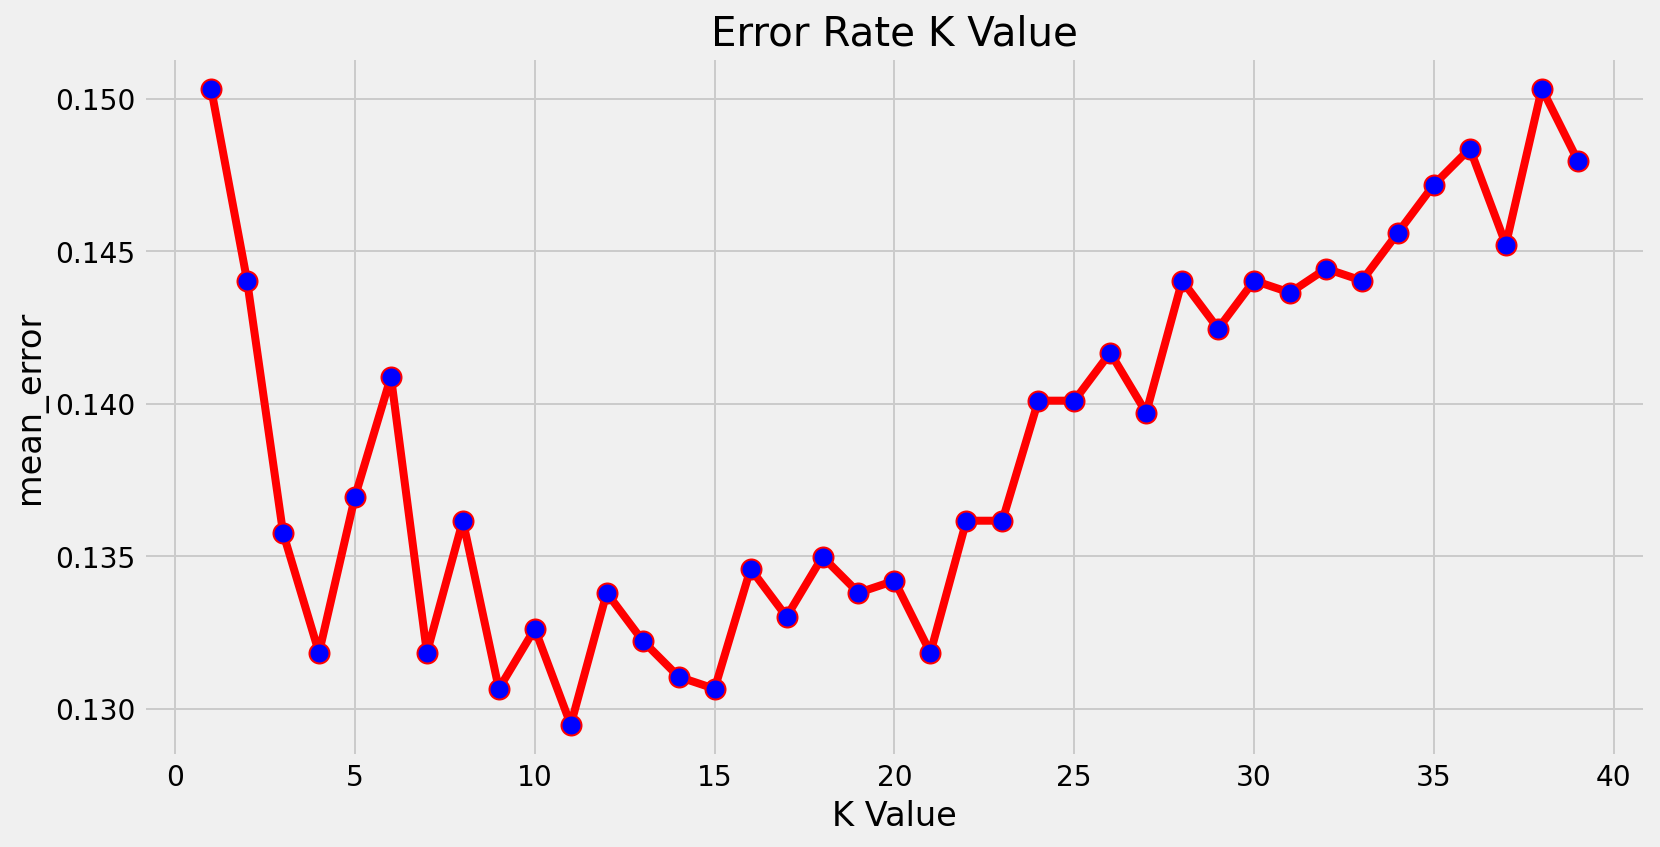

In [ ]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(data_train, labels_train)
    pred_i = knn.predict(data_test)
    error.append(np.mean(pred_i != labels_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red',linestyle='-', marker='o',markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('mean_error')
plt.show()

###LSTM

In [ ]:
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 280, 300)          15000000  
                                                                 
 lstm_7 (LSTM)               (None, 300)               721200    
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 301       
                                                                 
Total params: 15,721,501
Trainable params: 721,501
Non-trainable params: 15,000,000
_________________________________________________________________
None


In [ ]:
#Training the model
#The model is trained and Early Stopping is used to end training if the loss and/or accuracy don't improve within 3 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3)
hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/5
477/477 [==============================] - 435s 906ms/step - loss: 0.4472 - acc: 0.8219 - val_loss: 0.4108 - val_acc: 0.8269
Epoch 2/5
477/477 [==============================] - 515s 1s/step - loss: 0.3802 - acc: 0.8422 - val_loss: 0.2930 - val_acc: 0.8647
Epoch 3/5
477/477 [==============================] - 449s 941ms/step - loss: 0.2385 - acc: 0.8981 - val_loss: 0.1864 - val_acc: 0.9445
Epoch 4/5
477/477 [==============================] - 442s 926ms/step - loss: 0.2009 - acc: 0.9285 - val_loss: 0.1307 - val_acc: 0.9559
Epoch 5/5
477/477 [==============================] - 469s 983ms/step - loss: 0.1194 - acc: 0.9638 - val_loss: 0.0982 - val_acc: 0.9788


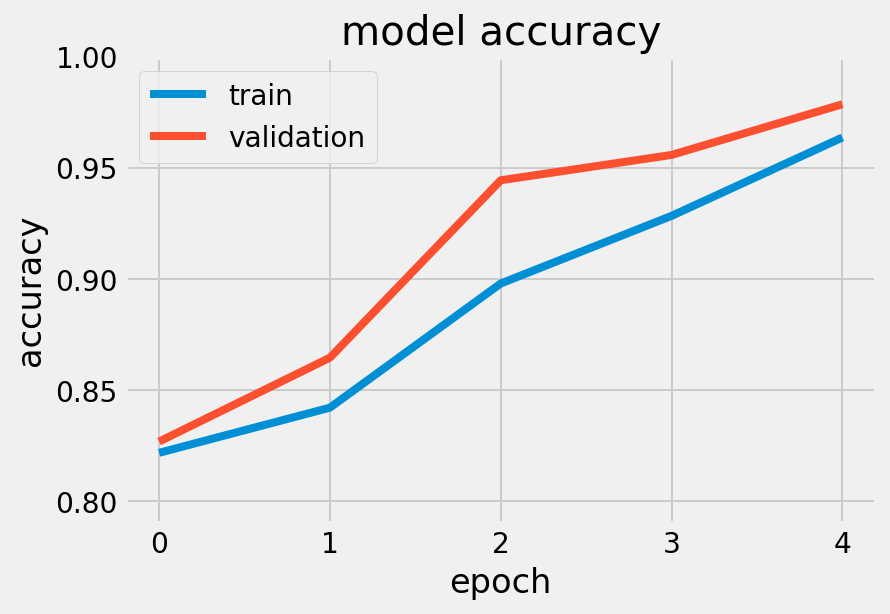

In [ ]:
#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.79,1)
plt.show()


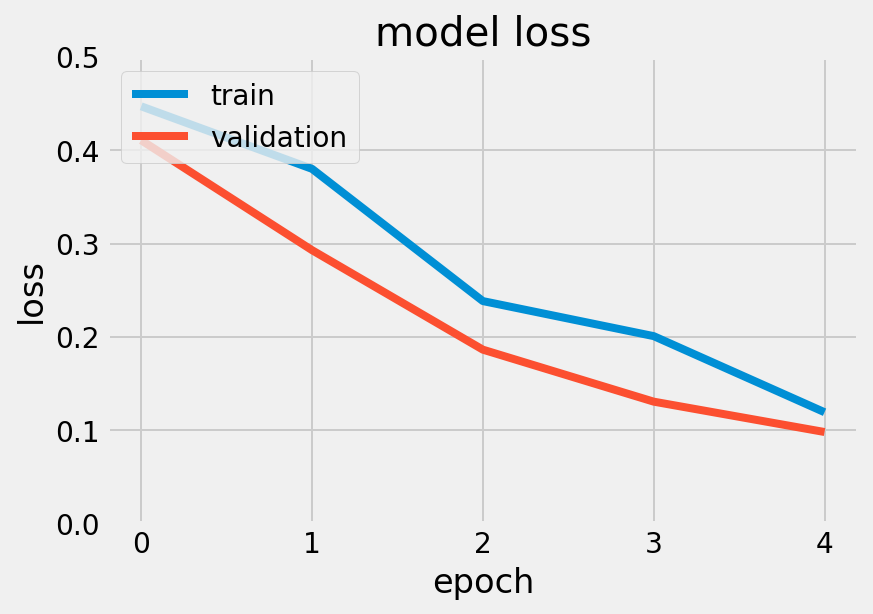

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.5))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 97.36%


In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2000
           1       0.99      0.88      0.93       541

    accuracy                           0.97      2541
   macro avg       0.98      0.94      0.96      2541
weighted avg       0.97      0.97      0.97      2541



###CNN+LSTM

In [ ]:
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
nadam = optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 300)          15000000  
                                                                 
 conv1d (Conv1D)             (None, 280, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 140, 32)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 140, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                      

In [ ]:
#Training the model
#The model is trained and Early Stopping is used to end training if the loss and/or accuracy don't improve within 3 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3)
hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/5
477/477 [==============================] - 197s 408ms/step - loss: 0.4689 - acc: 0.8119 - val_loss: 0.3697 - val_acc: 0.8568
Epoch 2/5
477/477 [==============================] - 199s 416ms/step - loss: 0.2261 - acc: 0.9225 - val_loss: 0.1213 - val_acc: 0.9705
Epoch 3/5
477/477 [==============================] - 201s 423ms/step - loss: 0.0954 - acc: 0.9725 - val_loss: 0.0732 - val_acc: 0.9862
Epoch 4/5
477/477 [==============================] - 201s 422ms/step - loss: 0.0744 - acc: 0.9810 - val_loss: 0.0610 - val_acc: 0.9874
Epoch 5/5
477/477 [==============================] - 201s 422ms/step - loss: 0.0648 - acc: 0.9849 - val_loss: 0.0562 - val_acc: 0.9882


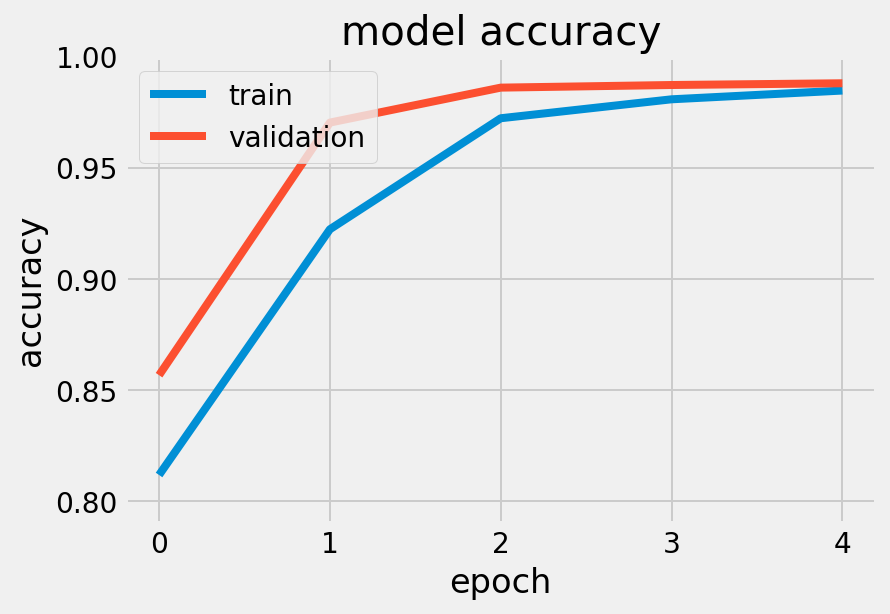

In [ ]:
#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.79,1)
plt.show()

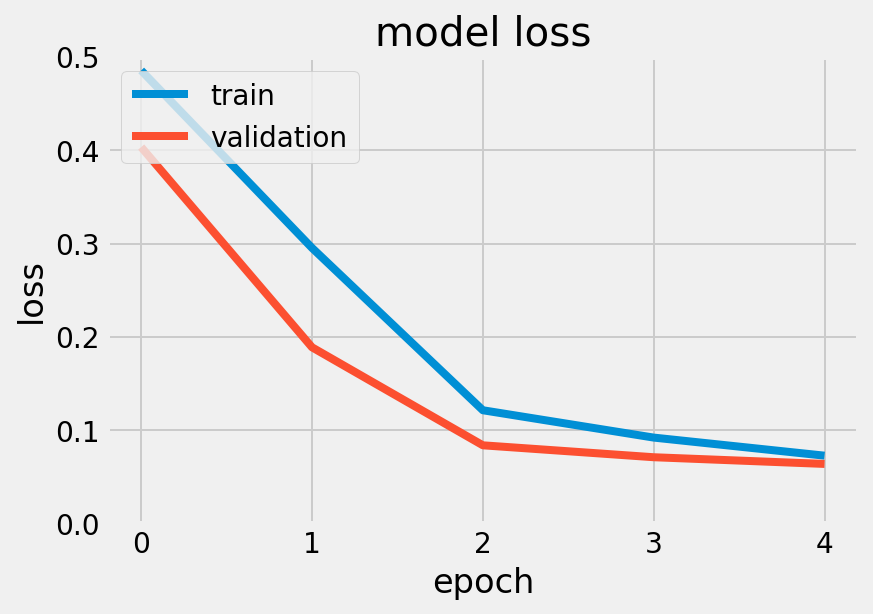

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.5))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.90%


In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2000
           1       1.00      0.95      0.97       541

    accuracy                           0.99      2541
   macro avg       0.99      0.98      0.98      2541
weighted avg       0.99      0.99      0.99      2541

